### SetUp

#### pip install

In [ ]:
# talib : 경제지수 라이브러리
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4051    0  4051    0     0   5314      0 --:--:-- --:--:-- --:--:--  5309
100  517k  100  517k    0     0   286k      0  0:00:01  0:00:01 --:--:--  872k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4087    0  4087    0     0   9263      0 --:--:-- --:--:-- --:--:--  9246
100  392k  100  392k    0     0   332k      0  0:00:01  0:00:01 --:--:--  332k


In [ ]:
# FinanceDataReader : 주가 데이터 라이브러리
!pip install finance-datareader

#### GoogleDrive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Library

In [ ]:
import pandas as pd
import numpy as np
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# 주가 데이터 및 경제지표
import FinanceDataReader as fdr
import yfinance as yf
import talib as ta

# ML
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import plot_importance

# Dl
import torch

# Huggingface
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

#### 시드 고정

In [ ]:
# 시드 값 설정
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

### Data

#### 삼성 주가

In [ ]:
stock_df = fdr.DataReader("005930", start = "2014-01-01", end = "2023-12-31") # 삼성전자 : 005930
stock_df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2014-01-02,26960,27100,26040,26180,620500,-0.045918
2014-01-03,26000,26220,25740,25920,529932,-0.009931
2014-01-06,26060,26399,25920,26140,394716,0.008488
2014-01-07,26000,26360,25900,26080,395264,-0.002295
2014-01-08,26000,26080,25740,25820,409493,-0.009969


In [ ]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2459 entries, 2014-01-02 to 2023-12-28
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2459 non-null   int64  
 1   High    2459 non-null   int64  
 2   Low     2459 non-null   int64  
 3   Close   2459 non-null   int64  
 4   Volume  2459 non-null   int64  
 5   Change  2459 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 134.5 KB


In [ ]:
stock_df.describe()

,Open,High,Low,Close,Volume,Change
count,2459.00000,2459.000000,2459.000000,2459.000000,2.459000e+03,2459.000000
mean,48788.53599,49233.029280,48327.416429,48834.188695,8.878529e+06,0.000554
std,18160.96831,18290.835625,18011.309649,18055.341382,9.584899e+06,0.015952
min,0.00000,0.000000,0.000000,21340.000000,0.000000e+00,-0.080357
25%,29519.50000,29770.000000,29200.000000,29560.000000,2.349515e+05,-0.009108
50%,47960.00000,48400.000000,47350.000000,47950.000000,8.693913e+06,0.000000
75%,61800.00000,62200.000000,61100.000000,61800.000000,1.441195e+07,0.009213
max,90300.00000,96800.000000,89500.000000,91000.000000,9.030618e+07,0.104706


In [ ]:
# 결측치 확인
stock_df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Change,0


#### 한경 뉴스데이터

In [ ]:
# root_path = "/content/drive/MyDrive/Colab Notebooks/hrd_2024_2/data/"

# name = [f"{year}0101-{year}1231" for year in range(2014, 2024)]
# file_names = [f"NewsResult_{period}.xlsx" for period in name]
# paths = [os.path.join(root_path, file_name) for file_name in file_names]

# dataframes = []

# for path in paths:
#     if not os.path.exists(path):
#         print(f"File does not exist: {path}")
#         continue
#     try:
#         df = pd.read_excel(path)  # 엑셀 파일을 읽어 데이터프레임으로 변환
#         dataframes.append(df)      # 데이터프레임을 리스트에 추가
#         print(f"Successfully read {path}")
#     except Exception as e:
#         print(f"Error reading {path}: {e}")

# if dataframes:
#     # 각 데이터프레임의 '일자' 컬럼을 내림차순으로 정렬
#     sorted_dataframes = [df.sort_values(by="일자", ascending=False) for df in dataframes]

#     # 모든 데이터프레임을 병합
#     combined_df = pd.concat(sorted_dataframes, ignore_index=True)
#     print("All dataframes have been concatenated and sorted by date successfully.")
# else:
#     print("No dataframes to concatenate.")

In [ ]:
# news_df = combined_df.copy()
# news_df.head(5)

In [ ]:
# # 시간이없는관계로, 직접적으로 확인가능한 요소들만 고려하겠음
# columns = [
#     '일자',
#     '제목',
#     '인물',
#     '위치',
#     '기관',
#     '키워드',
#     '특성추출(가중치순 상위 50개)',
#     '본문'
# ]

# news_df = news_df[columns]
# news_df.head()

In [ ]:
# news_df.info()

In [ ]:
# news_df = news_df.sort_values(by="일자", ascending=True)
# news_df.set_index("일자")
# news_df

##### 감정분석(완료) - news_df로 가져올것

In [ ]:
# KR-FinBert사용
tokenizer = AutoTokenizer.from_pretrained("snunlp/KR-FinBert-SC")
model = AutoModelForSequenceClassification.from_pretrained("snunlp/KR-FinBert-SC")

In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device="cuda")

In [ ]:
# 감성 분석할 열 지정
text_column = '제목' # 제목	인물, 위치, 기관, 키워드, 특성추출(가중치순 상위 50개), 본문

In [ ]:
# 새 임베딩 필요시 -> 다시 감성분석
tqdm.pandas()

def get_sentiment(text):
    try:
        result = sentiment_pipeline(text)[0]
        return result['label']
    except Exception as e:
        return 'Error'

news_df['감성'] = news_df[text_column].progress_apply(get_sentiment)

In [ ]:
news_df.to_csv("/content/drive/MyDrive/Colab Notebooks/hrd_2024_2/data/news_df.csv")

##### 감성분석 - news_df

In [ ]:
# score_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/hrd_2024_2/data/news_df.csv")

##### 일자별 스코어링으로 변환

In [ ]:
score_df = score_df[["일자", "감성"]]

# 스코어링
score_df['감성'] = score_df['감성'].map({
    "positive": 1,
    "negative": -1,
    "neutral": 0
})

score_df.head()

,일자,감성
0,20140101,0
1,20140101,1
2,20140101,0
3,20140101,-1
4,20140101,0


In [ ]:
score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56957 entries, 0 to 56956
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   일자      56957 non-null  int64
 1   감성      56957 non-null  int64
dtypes: int64(2)
memory usage: 890.1 KB


In [ ]:
score_df.describe(include = "all")

,일자,감성
count,5.695700e+04,56957.000000
mean,2.018166e+07,0.081799
std,2.854293e+04,0.685522
min,2.014010e+07,-1.000000
25%,2.016031e+07,0.000000
50%,2.018041e+07,0.000000
75%,2.021011e+07,1.000000
max,2.023123e+07,1.000000


In [ ]:
# 긍부정 수 판별
score_df["감성"].value_counts()

,count
감성,
0,29810
1,15903
-1,11244


In [ ]:
# 긍정 부정만 고려 - 중립 삭제
score_df = score_df[score_df["감성"] != 0]
score_df["감성"].value_counts()

,count
감성,
1,15903
-1,11244


In [ ]:
# '일자' 컬럼을 인덱스로 설정하고, 같은 일자를 기준으로 숫자 값을 합산
score_df_grouped = score_df.groupby("일자").mean()

# 인덱스를 '일자'로 설정
score_df_grouped.index.name = "Date"

# 결과 출력
score_df = score_df_grouped

# 일자 인덱스를 datetime 형식으로 변환 후 포맷 지정
score_df.index = pd.to_datetime(score_df.index, format='%Y%m%d').strftime('%Y-%m-%d')
score_df.index = pd.to_datetime(score_df.index) # 인덱스가 오브젝트로 바뀌어서 datetime으로 변환

In [ ]:
# stock_df와 score_df를 인덱스를 기준으로 병합
if 'score_df' in locals():
    fin_df = stock_df.merge(score_df, left_index=True, right_index=True, how="left")

else:
    fin_df = stock_df.copy()

# 결과 출력
fin_df.head()

,Open,High,Low,Close,Volume,Change,감성
Date,,,,,,,
2014-01-02,26960,27100,26040,26180,620500,-0.045918,-0.857143
2014-01-03,26000,26220,25740,25920,529932,-0.009931,-0.523810
2014-01-06,26060,26399,25920,26140,394716,0.008488,0.000000
2014-01-07,26000,26360,25900,26080,395264,-0.002295,-0.161290
2014-01-08,26000,26080,25740,25820,409493,-0.009969,0.130435


#### 삼성 시가총액

In [ ]:
# yahoo finance
ticker = yf.Ticker("005930.KS") # 삼성전자 : 005930.KS

# 20140101-20231231
data = ticker.history(start="2014-01-01", end="2023-12-31")

In [ ]:
# 발행 주식 수를 가져오기 (최근 값 사용)
outstanding_shares = ticker.info['sharesOutstanding']

# 시가총액 계산 (일별 종가 * 발행 주식 수)
data['Market Cap'] = data['Close'] * outstanding_shares

# 결과 확인
data = data['Market Cap']
data.head()

,Market Cap
Date,
2014-01-02 00:00:00+09:00,1.225071e+14
2014-01-03 00:00:00+09:00,1.212905e+14
2014-01-06 00:00:00+09:00,1.223199e+14
2014-01-07 00:00:00+09:00,1.220392e+14
2014-01-08 00:00:00+09:00,1.208225e+14


#### KOSPI 시가총액

In [ ]:
# 파일 경로 리스트
file_paths = [
    '/content/drive/MyDrive/Colab Notebooks/hrd_2024_2/data/data_5434_20241028.csv',
    '/content/drive/MyDrive/Colab Notebooks/hrd_2024_2/data/data_5453_20241028.csv',
    "/content/drive/MyDrive/Colab Notebooks/hrd_2024_2/data/data_5505_20241028.csv",
    '/content/drive/MyDrive/Colab Notebooks/hrd_2024_2/data/data_5519_20241028.csv',
    "/content/drive/MyDrive/Colab Notebooks/hrd_2024_2/data/data_5530_20241028.csv"
]

# 모든 CSV 파일을 읽어와서 데이터프레임으로 합치기
df_list = []

for file in file_paths:
    try:
        df = pd.read_csv(file, encoding = "cp949")
        df_list.append(df)
    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {file}")

# 데이터프레임 합치기
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    print("합쳐진 데이터프레임의 첫 5행:")
    print(combined_df.head())
else:
    print("합칠 데이터프레임이 없습니다.")


합쳐진 데이터프레임의 첫 5행:
           일자       종가     대비   등락률       시가       고가       저가        거래량  \
0  2023/12/28  2655.28  41.78  1.60  2616.27  2655.28  2611.72  460086621   
1  2023/12/27  2613.50  10.91  0.42  2599.35  2613.50  2590.08  349733378   
2  2023/12/26  2602.59   3.08  0.12  2609.44  2612.14  2594.65  440428129   
3  2023/12/22  2599.51  -0.51 -0.02  2617.72  2621.37  2599.51  465967201   
4  2023/12/21  2600.02 -14.28 -0.55  2598.37  2610.81  2587.16  578334789   

             거래대금            상장시가총액  
0   9418929602384  2126372515851046  
1  10359763878782  2093997127111758  
2   9582765574870  2085608165140366  
3   8848287882829  2082855844704432  
4   9467808991589  2080482827882262  


In [ ]:
total = combined_df[["일자", "상장시가총액"]]

In [ ]:
total = total.sort_values(by="일자", ascending=True)

In [ ]:
# "일자" 컬럼을 "Date"로 이름 변경
total.rename(columns={"일자": "Date"}, inplace=True)

# 날짜 형식을 "YYYY-MM-DD"로 변환
total['Date'] = pd.to_datetime(total['Date'], format='%Y/%m/%d').dt.strftime('%Y-%m-%d')
total['Date'] = pd.to_datetime(total['Date'], format='%Y-%m-%d')

# "Date" 컬럼을 인덱스로 설정
total.set_index("Date", inplace=True)

#### 최종 데이터프레임

In [ ]:
# data의 타임존 삭제
data.index = data.index.tz_localize(None)

In [ ]:
temp = pd.merge(fin_df, data, left_index=True, right_index=True, how='left')
temp2 = temp.merge(total, left_index=True, right_index=True, how='left')
fin_df = temp2

In [ ]:
fin_df["Sentiment degree"] = fin_df["감성"] * (fin_df["Market Cap"] / fin_df["상장시가총액"])
fin_df["Sensitive degree"] = fin_df["감성"].abs() * (fin_df["Market Cap"] / fin_df["상장시가총액"])
fin_df = fin_df.rename(columns={'감성': 'avg_score'})

In [ ]:
fin_df.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Change,0
avg_score,7
Market Cap,4
상장시가총액,0
Sentiment degree,11


In [ ]:
fin_df.drop(columns = ["avg_score", "Market Cap", "상장시가총액"], inplace = True)

In [ ]:
fin_df.head()

,Open,High,Low,Close,Volume,Change,Sentiment degree,Sensitive degree
Date,,,,,,,,
2014-01-02,26960,27100,26040,26180,620500,-0.045918,-0.090531,0.090531
2014-01-03,26000,26220,25740,25920,529932,-0.009931,-0.055382,0.055382
2014-01-06,26060,26399,25920,26140,394716,0.008488,0.000000,0.000000
2014-01-07,26000,26360,25900,26080,395264,-0.002295,-0.017040,0.017040
2014-01-08,26000,26080,25740,25820,409493,-0.009969,0.013641,0.013641


### PreProcessing

#### 결측치 확인

In [ ]:
fin_df.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Change,0
Sentiment degree,11
Sensitive degree,11


In [ ]:
# 결측치를 앞의 값으로 채우기
fin_df.fillna(method='ffill', inplace=True)

<ipython-input-337-565e12e3496b>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fin_df.fillna(method='ffill', inplace=True)


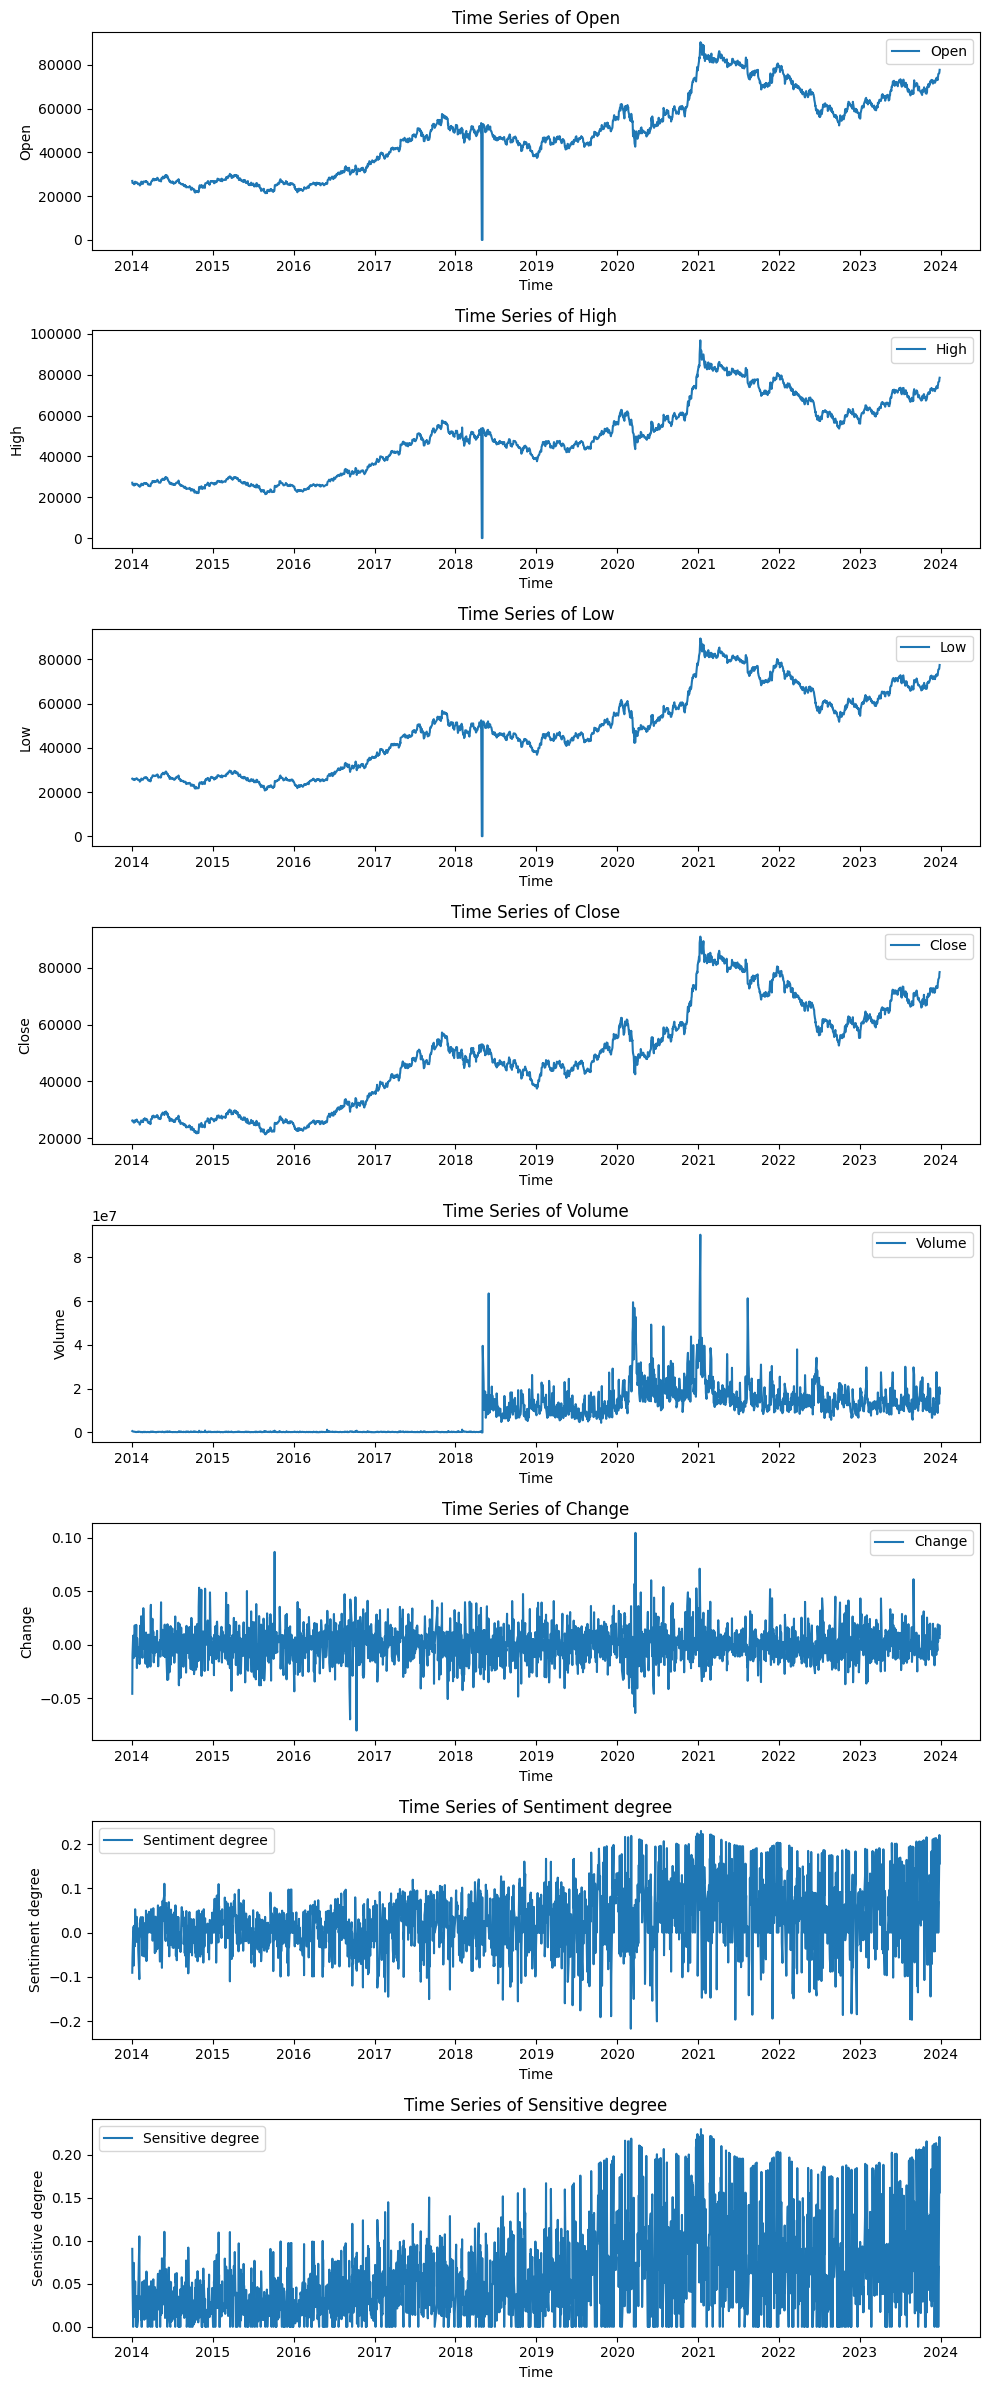

In [ ]:
# 서브플롯을 위해 열의 수 계산
num_cols = fin_df.shape[1]
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(10, num_cols * 3))

# 각 컬럼의 시계열 그래프 생성
for i, column in enumerate(fin_df.columns):
    axes[i].plot(fin_df.index, fin_df[column], label=column)
    axes[i].set_title(f'Time Series of {column}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(column)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
# "Open" 컬럼이 0이 아닌 행만 남기기 -> 액면분할 제거
fin_df = fin_df[fin_df["Open"] != 0]

#### 이상치 제거 : 시간이 없음 - 4분위수 활용

In [ ]:
# Q1 = fin_df.quantile(0.25)
# Q3 = fin_df.quantile(0.75)
# IQR = Q3 - Q1

# # 이상치 제거
# fin_df = fin_df[~((fin_df < (Q1 - 1.5 * IQR)) | (fin_df > (Q3 + 1.5 * IQR))).any(axis=1)]
# fin_df

### 피쳐 엔지니어링

In [ ]:
# TRIX 지표 추가
fin_df['TRIX'] = ta.TRIX(fin_df['Close'], timeperiod=30)

# ADX 지표 추가
fin_df['ADX'] = ta.ADX(fin_df['High'], fin_df['Low'], fin_df['Close'], timeperiod=14)

# BOP 지표 추가
fin_df['BOP'] = ta.BOP(fin_df['Open'], fin_df['High'], fin_df['Low'], fin_df['Close'])

# ADXR 지표 추가
fin_df['ADXR'] = ta.ADXR(fin_df['High'], fin_df['Low'], fin_df['Close'], timeperiod=14)

# fastK (Stochastic %K) 지표 추가
fin_df['fastK'], fin_df['fastD'] = ta.STOCHF(fin_df['High'], fin_df['Low'], fin_df['Close'], fastk_period=5, fastd_period=3, fastd_matype=0)

# MFI (Money Flow Index) 지표 추가
fin_df['MFI'] = ta.MFI(fin_df['High'], fin_df['Low'], fin_df['Close'], fin_df['Volume'], timeperiod=14)

# CMO (Chande Momentum Oscillator) 지표 추가
fin_df['CMO'] = ta.CMO(fin_df['Close'], timeperiod=14)

# DX (Directional Movement Index) 지표 추가
fin_df['DX'] = ta.DX(fin_df['High'], fin_df['Low'], fin_df['Close'], timeperiod=14)

# ma_macdhist 지표 추가 (MACD histogram의 이동평균)
macd, macdsignal, macdhist = ta.MACD(fin_df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
fin_df['ma_macdhist'] = ta.MA(macdhist, timeperiod=9)

# MINUS_DM (Negative Directional Movement) 지표 추가
fin_df['MINUS_DM'] = ta.MINUS_DM(fin_df['High'], fin_df['Low'], timeperiod=14)

<ipython-input-341-723c0bdb7e22>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_df['TRIX'] = ta.TRIX(fin_df['Close'], timeperiod=30)
<ipython-input-341-723c0bdb7e22>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_df['ADX'] = ta.ADX(fin_df['High'], fin_df['Low'], fin_df['Close'], timeperiod=14)
<ipython-input-341-723c0bdb7e22>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [ ]:
# 이동평균 계산코드
fin_df['Sentiment_degree_ma'] = fin_df['Sentiment degree'].rolling(window=90).mean()
fin_df['Sensitive_degree_ma'] = fin_df['Sensitive degree'].rolling(window=90).mean()

<ipython-input-342-7dbd6da098cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_df['Sentiment_degree_ma'] = fin_df['Sentiment degree'].rolling(window=90).mean()
<ipython-input-342-7dbd6da098cf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_df['Sensitive_degree_ma'] = fin_df['Sensitive degree'].rolling(window=90).mean()


In [ ]:
# 최종 사용 데이터셋 선정을 위한 드랍
# fin_df.drop(columns = ["Sentiment degree", "Sensitive degree"], inplace = True) # 실용성

fin_df.drop(columns = ["Sentiment degree", "Sensitive degree", "Open", "High", "Low", "Volume", "Change"], inplace = True) # 논문구현 : 주기자표 감성분석 적용 효과

<ipython-input-343-dd310fff4ee9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_df.drop(columns = ["Sentiment degree", "Sensitive degree", "Open", "High", "Low", "Volume", "Change"], inplace = True) # 논문구현 : 주기자표 감성분석 적용 효과


### 최종 데이터셋

In [ ]:
fin_df.head(10)

,Close,TRIX,ADX,BOP,ADXR,fastK,fastD,MFI,CMO,DX,ma_macdhist,MINUS_DM,Sentiment_degree_ma,Sensitive_degree_ma
Date,,,,,,,,,,,,,,
2014-01-02,26180,NaN,NaN,-0.735849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,25920,NaN,NaN,-0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,26140,NaN,NaN,0.167015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,26080,NaN,NaN,0.173913,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,25820,NaN,NaN,-0.529412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-09,25500,NaN,NaN,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-10,25440,NaN,NaN,-0.214286,NaN,0.000000,1.960784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-13,25900,NaN,NaN,0.500000,NaN,50.000000,16.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-14,26260,NaN,NaN,0.400000,NaN,70.689655,40.229885,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
fin_df.tail(10)

,Close,TRIX,ADX,BOP,ADXR,fastK,fastD,MFI,CMO,DX,ma_macdhist,MINUS_DM,Sentiment_degree_ma,Sensitive_degree_ma
Date,,,,,,,,,,,,,,
2023-12-14,73100,0.083821,17.748883,-0.555556,22.497453,50.000000,73.611111,69.322900,16.689660,19.402522,-102.361218,2721.999888,0.061906,0.103840
2023-12-15,73300,0.086067,17.867000,-0.625000,22.313725,52.380952,57.738095,75.498797,18.875746,19.402522,-95.894566,2527.571325,0.062990,0.102756
2023-12-18,72900,0.088071,17.428567,-0.666667,21.912746,22.222222,41.534392,69.436786,12.516589,11.728936,-81.089570,2747.030516,0.066397,0.103993
2023-12-19,73400,0.090019,17.021450,0.666667,21.540409,50.000000,41.534392,69.384527,18.393205,11.728936,-61.649545,2550.814050,0.067955,0.103371
2023-12-20,74800,0.092410,18.020733,0.545455,21.527617,95.833333,56.018519,69.650231,32.138861,31.011411,-28.837577,2368.613047,0.067364,0.102780
2023-12-21,75000,0.095185,19.024729,0.571429,21.761510,100.000000,81.944444,75.777596,33.852961,32.076674,4.319568,2199.426401,0.067065,0.102480
2023-12-22,75900,0.098555,20.819397,0.111111,21.894518,88.571429,94.801587,76.423461,41.066887,44.150087,39.490492,2042.324515,0.067494,0.102051
2023-12-26,76600,0.102610,22.707772,0.500000,22.128974,97.435897,95.335775,83.059208,45.999731,47.256650,75.408058,1896.444192,0.067071,0.101628
2023-12-27,78000,0.107680,25.075185,0.866667,22.924186,100.000000,95.335775,84.240327,54.247999,55.851555,124.629666,1760.983893,0.067369,0.101926


In [ ]:
fin_df.corr()

,Close,TRIX,ADX,BOP,ADXR,fastK,fastD,MFI,CMO,DX,ma_macdhist,MINUS_DM,Sentiment_degree_ma,Sensitive_degree_ma
Close,1.000000,0.126231,0.003926,-0.030593,0.009614,-0.008016,-0.011818,-0.045365,0.045604,0.000553,0.005914,0.500627,0.896071,0.945037
TRIX,0.126231,1.000000,0.274451,0.020757,0.331304,0.014336,0.030915,0.230681,0.387970,0.112281,-0.211912,-0.153112,0.098899,0.072799
ADX,0.003926,0.274451,1.000000,-0.003495,0.868800,0.029884,0.050931,0.107545,0.197043,0.565694,0.051063,0.004982,0.012116,-0.012444
BOP,-0.030593,0.020757,-0.003495,1.000000,-0.008451,0.532925,0.174382,0.141375,0.270949,0.036509,0.047252,-0.086454,-0.073727,-0.049091
ADXR,0.009614,0.331304,0.868800,-0.008451,1.000000,0.028985,0.043815,0.099334,0.190284,0.311770,-0.018929,0.017511,0.032929,-0.005875
fastK,-0.008016,0.014336,0.029884,0.532925,0.028985,1.000000,0.782205,0.388705,0.621504,0.100461,0.132499,-0.277773,-0.070740,-0.050551
fastD,-0.011818,0.030915,0.050931,0.174382,0.043815,0.782205,1.000000,0.498487,0.684490,0.124743,0.237874,-0.349398,-0.084287,-0.061975
MFI,-0.045365,0.230681,0.107545,0.141375,0.099334,0.388705,0.498487,1.000000,0.785832,0.127301,0.588375,-0.439789,-0.132551,-0.081595
CMO,0.045604,0.387970,0.197043,0.270949,0.190284,0.621504,0.684490,0.785832,1.000000,0.191568,0.513578,-0.546584,-0.051117,-0.030126
DX,0.000553,0.112281,0.565694,0.036509,0.311770,0.100461,0.124743,0.127301,0.191568,1.000000,0.083315,-0.045511,-0.005680,-0.013435


### 데이터 분할

In [ ]:
# 데이터 준비
X = fin_df.drop(columns=['Close'])
X.fillna(method = "bfill", inplace = True)
y = fin_df['Close']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<ipython-input-347-7c27e177571c>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method = "bfill", inplace = True)


### 스케일링

In [ ]:
# MinMax
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Quantile
# scaler = QuantileTransformer()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [ ]:
# TimeSeriesSplit 설정
tscv = TimeSeriesSplit(n_splits=5)

# XGBoost 모델 학습 (GPU 사용, 시드 고정, 기본 하이퍼파라미터)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', device="cuda", random_state=seed_value)
xgb_model.fit(X_train_scaled, y_train)

# XGBoost 예측
xgb_pred_train = xgb_model.predict(X_train_scaled)
xgb_pred_test = xgb_model.predict(X_test_scaled)

# RandomForest 모델 학습 (시드 고정, 기본 하이퍼파라미터)
rf_model = RandomForestRegressor(random_state=seed_value)
rf_model.fit(X_train_scaled, y_train)

# RandomForest 예측
rf_pred_train = rf_model.predict(X_train_scaled)
rf_pred_test = rf_model.predict(X_test_scaled)

Test Data Scoring:
XGBoost Test RMSE: 8711.4482
XGBoost Test R²: -1.1428
RandomForest Test RMSE: 8437.8797
RandomForest Test R²: -1.0103


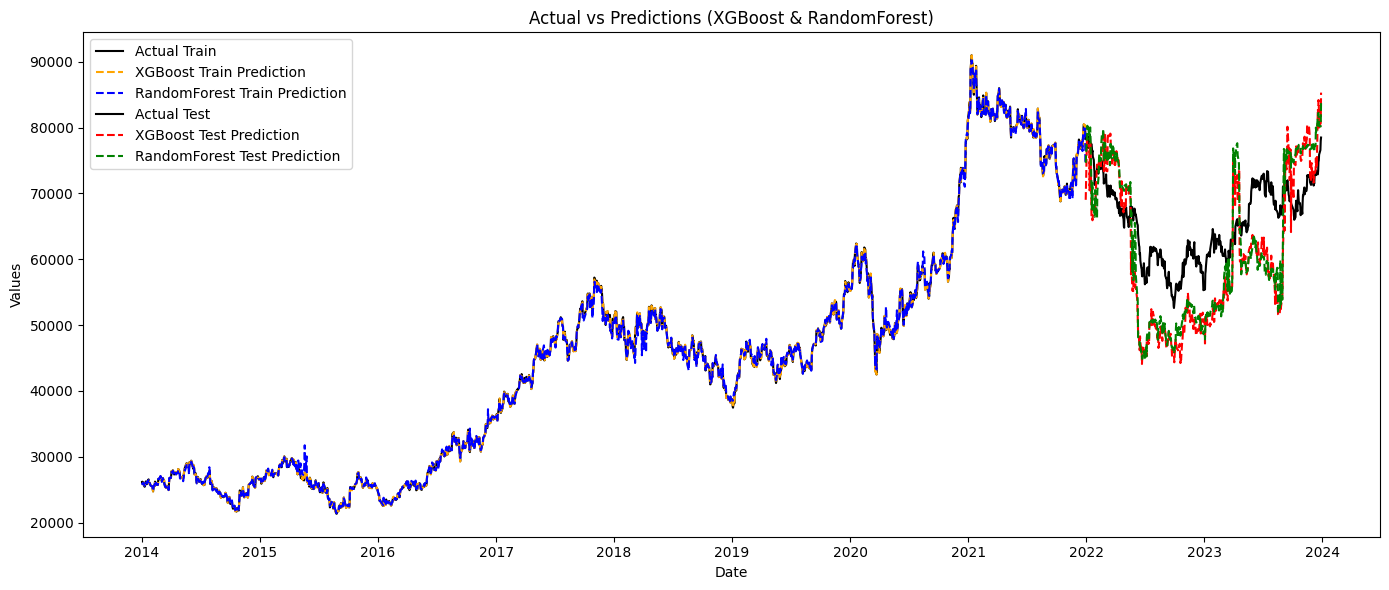

In [ ]:
# 스코어링 함수
def calculate_scores(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} RMSE: {rmse:.4f}")
    print(f"{model_name} R²: {r2:.4f}")
    return rmse, r2

# 두 모델의 예측값 비교 시각화 함수
def plot_combined_predictions(y_train, y_test, xgb_train_pred, xgb_test_pred, rf_train_pred, rf_test_pred):
    plt.figure(figsize=(14, 6))

    # Train 데이터 실제 값
    plt.plot(y_train.index, y_train, label="Actual Train", color='black', linestyle='-')
    # Train 데이터 XGBoost 예측 값
    plt.plot(y_train.index, xgb_train_pred, label="XGBoost Train Prediction", color='orange', linestyle='--')
    # Train 데이터 RandomForest 예측 값
    plt.plot(y_train.index, rf_train_pred, label="RandomForest Train Prediction", color='blue', linestyle='--')

    # Test 데이터 실제 값
    plt.plot(y_test.index, y_test, label="Actual Test", color='black', linestyle='-')
    # Test 데이터 XGBoost 예측 값
    plt.plot(y_test.index, xgb_test_pred, label="XGBoost Test Prediction", color='red', linestyle='--')
    # Test 데이터 RandomForest 예측 값
    plt.plot(y_test.index, rf_test_pred, label="RandomForest Test Prediction", color='green', linestyle='--')

    plt.title("Actual vs Predictions (XGBoost & RandomForest)")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 스코어 계산 및 출력
print("Test Data Scoring:")
xgb_test_rmse, xgb_test_r2 = calculate_scores(y_test, xgb_pred_test, "XGBoost Test")
rf_test_rmse, rf_test_r2 = calculate_scores(y_test, rf_pred_test, "RandomForest Test")

# 두 모델 예측값을 포함한 시각화
plot_combined_predictions(y_train, y_test, xgb_pred_train, xgb_pred_test, rf_pred_train, rf_pred_test)

# 1 XGBoost Test RMSE: 14960.2674
# 1 XGBoost Test R²: -5.3193

# 7 XGBoost Test RMSE: 13471.0068
# 7 XGBoost Test R²: -4.1238

# 15 XGBoost Test RMSE: 11927.7941
# 15 XGBoost Test R²: -3.0171

# 30 XGBoost Test RMSE: 9655.4996
# 30 XGBoost Test R²: -1.6323

# 90 XGBoost Test RMSE: 8711.4482
# 90 XGBoost Test R²: -1.1428

                Feature  fscore
0                  TRIX   728.0
1                   ADX   381.0
11  Sentiment_degree_ma   367.0
2                   BOP   357.0
12  Sensitive_degree_ma   312.0
6                   MFI   307.0
4                 fastK   300.0
3                  ADXR   296.0
10             MINUS_DM   292.0
5                 fastD   281.0
7                   CMO   281.0
8                    DX   274.0
9           ma_macdhist   232.0


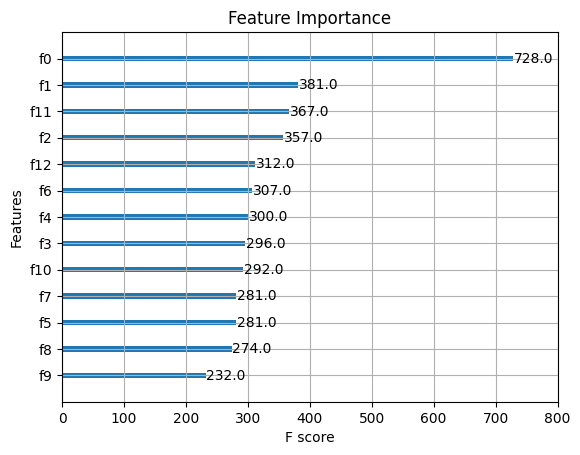

In [ ]:
# 수정된 피처 이름 목록
feature_names = list(X.columns)

# xgb_model에서 피처 중요도(fscore) 추출
feature_importance = xgb_model.get_booster().get_score(importance_type='weight')

# 피처 이름과 중요도를 데이터프레임으로 변환
feature_importance_df = pd.DataFrame(
    [(feature_names[int(key[1:])], score) for key, score in feature_importance.items()],
    columns=['Feature', 'fscore']
).sort_values(by='fscore', ascending=False)

# 피처 중요도 데이터프레임 출력
print(feature_importance_df)

# 중요도 시각화
plot_importance(xgb_model, importance_type='weight', title="Feature Importance")
plt.show()

### 비교군

In [ ]:
X_vs = X.drop(columns=['Sentiment_degree_ma', 'Sensitive_degree_ma']) # 감성분석 제거

In [ ]:
X

,TRIX,ADX,BOP,ADXR,fastK,fastD,MFI,CMO,DX,ma_macdhist,MINUS_DM,Sentiment_degree_ma,Sensitive_degree_ma
Date,,,,,,,,,,,,,
2014-01-02,0.117212,17.952427,-0.735849,18.700450,0.000000,1.960784,35.922003,11.801242,24.122836,103.547876,880.000000,0.004178,0.027121
2014-01-03,0.117212,17.952427,-0.166667,18.700450,0.000000,1.960784,35.922003,11.801242,24.122836,103.547876,880.000000,0.004178,0.027121
2014-01-06,0.117212,17.952427,0.167015,18.700450,0.000000,1.960784,35.922003,11.801242,24.122836,103.547876,880.000000,0.004178,0.027121
2014-01-07,0.117212,17.952427,0.173913,18.700450,0.000000,1.960784,35.922003,11.801242,24.122836,103.547876,880.000000,0.004178,0.027121
2014-01-08,0.117212,17.952427,-0.529412,18.700450,0.000000,1.960784,35.922003,11.801242,24.122836,103.547876,880.000000,0.004178,0.027121
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,0.095185,19.024729,0.571429,21.761510,100.000000,81.944444,75.777596,33.852961,32.076674,4.319568,2199.426401,0.067065,0.102480
2023-12-22,0.098555,20.819397,0.111111,21.894518,88.571429,94.801587,76.423461,41.066887,44.150087,39.490492,2042.324515,0.067494,0.102051
2023-12-26,0.102610,22.707772,0.500000,22.128974,97.435897,95.335775,83.059208,45.999731,47.256650,75.408058,1896.444192,0.067071,0.101628


Test Data Scoring:
XGBoost Test RMSE: 15756.8648
XGBoost Test R²: -6.0102
RandomForest Test RMSE: 15759.2083
RandomForest Test R²: -6.0123


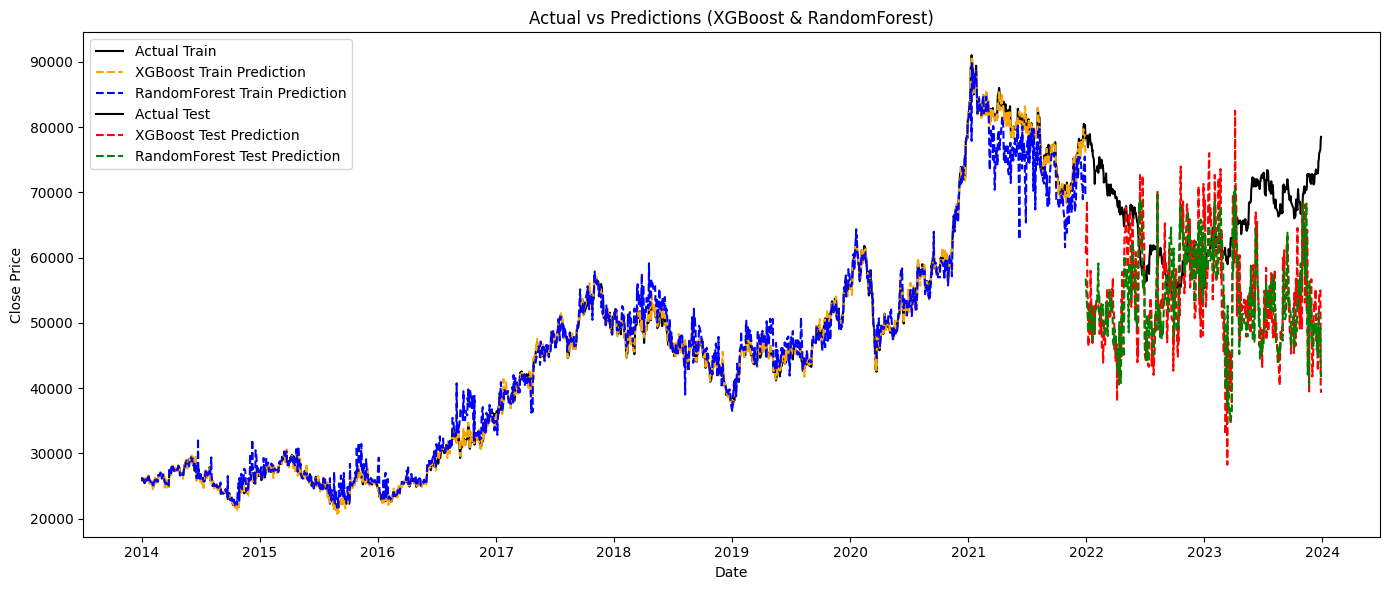

In [ ]:
# Train/Test 분할 : X_vs에 대해서
X_train, X_test, y_train, y_test = train_test_split(X_vs, y, test_size=0.2, shuffle=False)

# 데이터 스케일링
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# TimeSeriesSplit 설정
tscv = TimeSeriesSplit(n_splits=5)

# XGBoost 모델 학습 (기본 하이퍼파라미터)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', device="cuda", random_state=seed_value)
xgb_model.fit(X_train_scaled, y_train)

# XGBoost 예측
xgb_pred_train = xgb_model.predict(X_train_scaled)
xgb_pred_test = xgb_model.predict(X_test_scaled)

# RandomForest 모델 학습 (기본 하이퍼파라미터)
rf_model = RandomForestRegressor(random_state=seed_value)
rf_model.fit(X_train_scaled, y_train)

# RandomForest 예측
rf_pred_train = rf_model.predict(X_train_scaled)
rf_pred_test = rf_model.predict(X_test_scaled)

# 스코어링 함수
def calculate_scores(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} RMSE: {rmse:.4f}")
    print(f"{model_name} R²: {r2:.4f}")
    return rmse, r2

# 두 모델의 예측값 비교 시각화 함수
def plot_combined_predictions(y_train, y_test, xgb_train_pred, xgb_test_pred, rf_train_pred, rf_test_pred):
    plt.figure(figsize=(14, 6))

    # Train 데이터 실제 값
    plt.plot(y_train.index, y_train, label="Actual Train", color='black', linestyle='-')
    # Train 데이터 XGBoost 예측 값
    plt.plot(y_train.index, xgb_train_pred, label="XGBoost Train Prediction", color='orange', linestyle='--')
    # Train 데이터 RandomForest 예측 값
    plt.plot(y_train.index, rf_train_pred, label="RandomForest Train Prediction", color='blue', linestyle='--')

    # Test 데이터 실제 값
    plt.plot(y_test.index, y_test, label="Actual Test", color='black', linestyle='-')
    # Test 데이터 XGBoost 예측 값
    plt.plot(y_test.index, xgb_test_pred, label="XGBoost Test Prediction", color='red', linestyle='--')
    # Test 데이터 RandomForest 예측 값
    plt.plot(y_test.index, rf_test_pred, label="RandomForest Test Prediction", color='green', linestyle='--')

    plt.title("Actual vs Predictions (XGBoost & RandomForest)")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 스코어 계산 및 출력
print("Test Data Scoring:")
xgb_test_rmse, xgb_test_r2 = calculate_scores(y_test, xgb_pred_test, "XGBoost Test")
rf_test_rmse, rf_test_r2 = calculate_scores(y_test, rf_pred_test, "RandomForest Test")

# 두 모델 예측값을 포함한 시각화
plot_combined_predictions(y_train, y_test, xgb_pred_train, xgb_pred_test, rf_pred_train, rf_pred_test)

# XGBoost Test RMSE: 15756.8648
# XGBoost Test R²: -6.0102